In [1]:
# Basic Imports
import pathlib
from pathlib import Path
import os
import sys
from typing import Any, Sequence, Optional, Tuple, Iterator, Dict, Callable, Union
import json
import time
from tqdm.auto import tqdm
import numpy as np
from copy import copy
from glob import glob
from collections import defaultdict
import matplotlib.pyplot as plt

# Changing fonts to be latex typesetting
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'dejavuserif'
rcParams['font.family'] = 'serif'

# JAX/Flax
import jax
from jax import jit
import jax.numpy as jnp
from jax import random

# PyTorch for Dataloaders
import torch
import torch.utils.data as data
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision.datasets import MNIST, CIFAR10
from torchvision import transforms

# Import created functions
import make_dataset as mkds
import visualization as vis

from numpy.random import default_rng
key = random.PRNGKey(42)
rng = default_rng(np.asarray(key))

# **Goal of this Notebook**: Perturb MNIST dataset and put it into a dataloader

TODO:
- Create custom dataset that perturbs the pytorch dataset and outputs the perturbed MNIST images with the Empirical field

In [2]:
# Download raw MNIST data
train_ds, test_ds = mkds.download_MNIST()
# Convert the data and labels into numpy arrays
train_data, train_labels = train_ds.data.numpy(), train_ds.targets.numpy()
test_data, test_labels = test_ds.data.numpy(), test_ds.targets.numpy()

# Add additional channel dimension for shape compatibility for perturbing func
train_data = mkds.reshape_with_channel_dim(train_data)
test_data = mkds.reshape_with_channel_dim(test_data)

**NOTE:** The perturbation hyperparameters have to larger than usual when running the `process_perturbed_data` function.

- Further testing needs to be done to figure out why, but as of right now, I'll continue on and come back to this once the model is working.

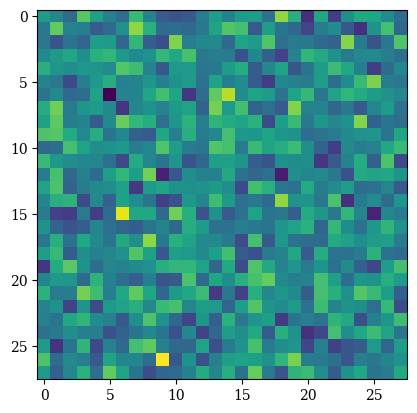

In [27]:
key, subkey1, subkey2 = jax.random.split(key, num=3)

# Perturb the data
perturbed_training = mkds.process_perturbed_data(train_data, subkey1, sigma=0.01, tau=0.06, M=450)
plt.imshow(perturbed_training[0][2500][:784].reshape((28,28)))

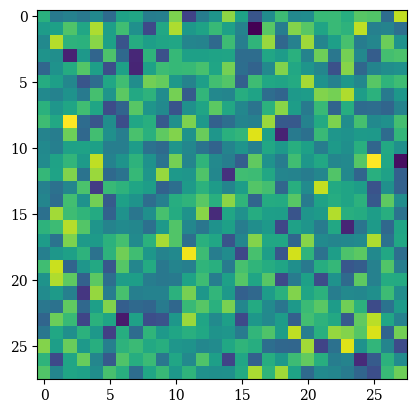

In [28]:
perturbed_test = mkds.process_perturbed_data(test_data, subkey2, sigma=0.01, tau=0.06, M=450)
plt.imshow(perturbed_test[0][20][:784].reshape((28,28)))

In [29]:
mkds.save_data(perturbed_training, 
               directory='/pscratch/sd/m/mdowicz/PFGM_MNIST/saved_data/MNIST/perturbed/',
               filename='perturbed_training.pkl')

mkds.save_data(perturbed_test, 
               directory='/pscratch/sd/m/mdowicz/PFGM_MNIST/saved_data/MNIST/perturbed/',
               filename='perturbed_test.pkl')

In [30]:
perturbed_training = mkds.load_data(data_dir='/pscratch/sd/m/mdowicz/PFGM_MNIST/saved_data/MNIST/perturbed/',
                                     data_file='perturbed_training.pkl')

perturbed_test = mkds.load_data(data_dir='/pscratch/sd/m/mdowicz/PFGM_MNIST/saved_data/MNIST/perturbed/',
                                     data_file='perturbed_test.pkl')



In [38]:
def create_perturbed_dataset(data_dir: str,
                             filename: str, 
                             sigma: float = 0.01, 
                             tau: float = 0.06, 
                             M: int = 450):
    """
    Function that perturbs raw MNIST datasets and returns perturbed data and empirical field 
    targets.
    
    Args:
    -----
        data_dir: str
            The path to the directory that we want the perturbed dataset to be saved to.
        filename: str
            The name of the saved data file.
            
    Returns:
    -------
        perturbed_dataset: tuple
            Tuple containing the perturbed data & targets.
    """
    # Download raw MNIST data
    train_ds, test_ds = mkds.download_MNIST()
    # Convert the data and labels into numpy arrays
    train_data, train_labels = train_ds.data.numpy(), train_ds.targets.numpy()
    test_data, test_labels = test_ds.data.numpy(), test_ds.targets.numpy()

    # Add additional channel dimension for shape compatibility for perturbing func
    train_data = mkds.reshape_with_channel_dim(train_data)
    test_data = mkds.reshape_with_channel_dim(test_data)
    
    # Instantiate the JAX rng to allow for different perturbations to be applied to 
    # the different datasets
    key, subkey1, subkey2 = jax.random.split(key, num=3)

    # Perturb the data
    perturbed_training = mkds.process_perturbed_data(train_data, subkey1, sigma=sigma, tau=tau, M=M)
    perturbed_test = mkds.process_perturbed_data(test_data, subkey2, sigma=sigma, tau=tau, M=M)
    

In [31]:
class PerturbMNIST:
    """
    Simple dataset class that stores the data and targets as NumPy arrays.
    
    Args:
    -----
        data: np.ndarray
            The perturbed input data.
        targets: np.ndarray
            The empirical field that generated the perturbed data.
    """
    def __init__(self, data: np.ndarray, targets: np.ndarray):
        self.data = data
        self.targets = targets
        
    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.targets)
    
    def __get_item__(self, idx: int):
        """
        Returns the i-th sample and corresponding target in the dataset.
        
        Args:
        -----
            idx: int
                The index of the sample to return.
                
        Returns:
        --------
            tuple: A tuple containing the sample and target.
        """
        sample = self.data[idx]
        target = self.targets[idx]
        return sample, target
    
def get_dataloader(dataset: Any, batch_size: int, shuffle: bool = True):
    """
    A dataloader function that returns batches of samples and targets.
    
    Args:
    -----
        dataset: PerturbMNIST
            The dataset to use.
        batch_size: int
            The number of samples per batch.
        shuffle: bool
            Whether to shuffle the data before iterating. Usually
            shuffle = True for training data.
        
    Returns:
    -------
        tuple: 
            A tuple containing the batch of samples and targets.
    """
    num_samples = len(dataset)
    indices = np.arange(num_samples)
    if shuffle:
        np.random.shuffle(indices)
    
    for start_idx in range(0, num_samples, batch_size):
        end_idx = min(start_idx + batch_size, num_samples)
        batch_indices = indices[start_idx: end_idx]
        batch_samples = dataset.data[batch_indices]
        batch_targets = dataset.targets[batch_indices]
        yield batch_samples, batch_targets

In [32]:
dataset = PerturbMNIST(perturbed_training[0], perturbed_training[1])
dataloader = get_dataloader(dataset, batch_size=32, shuffle=True)

In [33]:
batch = next(iter(dataloader))

In [37]:
batch[0][0]

array([ 2.93281504e+08, -7.80605632e+08,  1.13351053e+09, -3.33852384e+08,
        4.89480640e+08,  6.78284544e+08,  2.80951200e+08, -1.27023859e+09,
        1.23057421e+09, -2.68376112e+08,  1.61813197e+09, -5.14530656e+08,
        9.99986160e+07,  1.17927376e+08, -5.47955050e+06, -3.38965760e+08,
        8.11148544e+08,  2.89561088e+09,  1.38326208e+09,  2.07565146e+09,
       -7.45269696e+08, -2.62152752e+08, -5.45115328e+08,  4.22276768e+08,
        1.33606170e+09, -5.55944840e+07,  1.82069325e+09, -1.40025139e+09,
       -1.28361907e+09,  8.26757696e+08, -9.06784384e+08,  2.37274608e+08,
       -1.31438488e+08, -1.65047987e+09,  3.36840416e+08,  8.06843456e+08,
        8.71717568e+08,  5.17793792e+08,  2.91230976e+08,  1.02530989e+09,
        4.01721152e+08,  4.26134496e+08, -4.67585440e+07, -1.04546573e+09,
       -3.21788832e+08,  1.46444762e+09, -5.95536512e+08, -4.01416960e+07,
        5.86980416e+08,  2.43402848e+08,  2.02267597e+09,  6.46269760e+08,
        6.15691968e+08, -

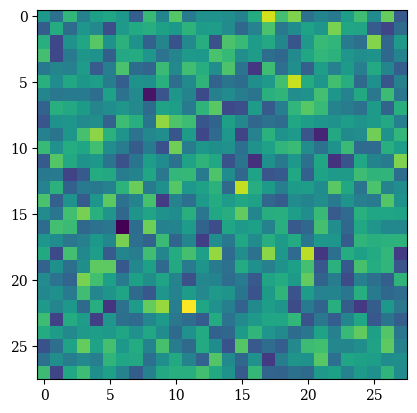

In [35]:
plt.imshow(batch[0][0][:784].reshape((28,28)))